# OCF Coding Challenge

# Task: Forecast Carbon Intensity Grid Next 24h (30 min intervals)

## Carbon Intensity

- Carbon intensity of electricity grid measures how much C02 emmisions are produced is generated in the production of a KWh of energy
- Carbon intensity depends on the mix of generation supplying the grid, including renewable sources, nuclear, gas, biomass and many more

## Problem

Can we train a model to predict carbon intensity of the grid with a 24h forecast in 30-minute time intervals?

**Forecast horizon:** 24 hours (30-minute intervals)

## Task Requirements

1. Full day prediction - 24h in 30mins = 48 predictions
2. Use demand + energy production forecasts from previous days for the prediction of the next 24 hours

## Key Considerations

1. Is the data stationary and is there any seasonality (yearly, monthly, daily)

## Model Evaluation

1. Time-based Cross-Validation to ensure model generalizes well.
2. Regression Metrics: RMSE and MAPE. 

## Extra Features and some Engineering

1. Add date/time features to incorporate information about important dates
2. Add lag features
3. Add forecasts of energy generation mix (proportions of different energy sources)


<!-- 
----
### Potential Extra Variables: 
1. Extra variables could include: Weather Data (Temp, wind, solar), Event data (Public Holidays, Weekends) 
2. Other non-renewable energies sich as coal, gas, oil and nuclear. As those are the main contributors to increased carbon intensity. 


### Potential Models: 
1. Time-serie Statistical models that capture trends in seasonality: 
    - ARIMA, SARIMA

2. ML Regression models: 
    - Classic Regressors 
    - Ensembles (Is what the API model is using now.)
    - NN approaches: LSTM + xLSTM. 



### Trying to understand the model behaviours a bit more:
1. Using feature importance + Explainability. 


--- -->


## This notebook will be mainly looking at Exploratory data Analysis of the provided Carbon Intensity data:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller


In [2]:
# Some misc Functions: 
def clean_column_names(columns):
    """
        Clean column names by removing quotes, converting to lowercase, and replacing spaces with underscores.

    """
    return (pd.Series(columns)
            .str.replace('"', '', regex=False)       
            .str.lower()                             
            .str.replace(' ', '_', regex=False)  
    )


In [3]:
# Load data / Clean Column names
data_df = pd.read_csv("../data/data.csv", index_col="from")
data_df.index.name = "Date"
data_df.index = pd.to_datetime(data_df.index)   # Need datatime object
data_df.index = data_df.index.tz_localize(None) # Remove timezone
data_df.columns = clean_column_names(data_df.columns)
data_df.head(5)

,carbon_intensity_actual,carbon_intensity_forecast,demand,solar,wind_offshore,wind_onshore
Date,,,,,,
2022-01-01 00:00:00,74.0,74,21690,0.0,6480.583,4739.050
2022-01-01 00:30:00,75.0,70,21830,0.0,6480.583,4739.050
2022-01-01 01:00:00,73.0,70,21335,0.0,6708.648,5380.218
2022-01-01 01:30:00,68.0,61,20239,0.0,6708.648,5380.218
2022-01-01 02:00:00,71.0,62,19224,0.0,6978.515,6059.516


## Understanding the Data - Definitions and Units

**Data Range:** January 1, 2022 - January 1, 2023

### Measurements and Forecasts

1. **Carbon Intensity**
   - **Actual:** Measured carbon generated from energy sources
   - **Forecast:** Projected carbon generation
   - **Unit:** gCO₂/kWh (grams of CO₂ per kilowatt-hour)

2. **Energy Demand**
   - **Forecast:** Projected energy consumption for grid-connected population
   - **Unit:** MW (megawatts)

3. **Renewable Generation**
   - **Solar Forecast:** Projected solar energy generation
   - **Wind Offshore Forecast:** Projected offshore wind generation
   - **Wind Onshore Forecast:** Projected onshore wind generation
   - **Unit:** MW (megawatts)

## Current Forecast Error: 

As we are already given a forecast for carbon intensity, let's look at it a bit closer: 


- As there are a couple nan values, lets just drop those rows for now. 

In [4]:
rmse = root_mean_squared_error(data_df.dropna()["carbon_intensity_actual"], data_df.dropna()["carbon_intensity_forecast"])
mae = mean_absolute_percentage_error(data_df.dropna()["carbon_intensity_actual"], data_df.dropna()["carbon_intensity_forecast"])
print(f"RMSE of current Forecast is {rmse.item():.5} gCO₂/kWh.")
print(f"Mean Absolute Percentage Error of current Forecast is {mae.item() * 100:.3}%.")


RMSE of current Forecast is 13.583 gCO₂/kWh.
Mean Absolute Percentage Error of current Forecast is 6.43%.


- Great, as we can see, the current forecast is already pretty good, with a MAPE of 6.41%. However, this projection is likely taken from some model that has been developed over quite some time, and contains lots of different features. 

- Let's see if we can get close to this projection using only the features we were initially give. We can always add some more later. 

## Dealing with NaN values: 

- Missing values in our dataset can significantly impact model performance, especially in timeseries, where they can disrupt patterns. 
- Let's have a look at what we are dealing with: 

In [5]:
print(data_df.isnull().sum())
data_df[data_df.isnull().any(axis=1)].head()

carbon_intensity_actual       51
carbon_intensity_forecast      0
demand                         0
solar                        288
wind_offshore                288
wind_onshore                 288
dtype: int64


,carbon_intensity_actual,carbon_intensity_forecast,demand,solar,wind_offshore,wind_onshore
Date,,,,,,
2022-03-26 18:00:00,NaN,244,31327,118.0,1396.742,913.989
2022-03-26 18:30:00,NaN,240,32100,0.0,1396.742,913.989
2022-03-26 19:00:00,NaN,241,32087,0.0,1456.941,859.678
2022-03-26 19:30:00,NaN,244,31165,0.0,1456.941,859.678
2022-03-26 20:00:00,NaN,247,30135,0.0,1463.062,842.929


- We can see that we have missing values in the actual carbon intensity, as well as in our forecasts of wind and solar energy.
- These missing values are contained over 339 rows. 


There are different ways of dealing with missing values: 
1. If small amounts, we can just remove them from the data - but this can cause loss of information in timeseries
2. We can interpolate the gap by using surrounding data from surrounding dates. 
3. We can take the global statistical measures such as mean/median ect - But this can bias the data quite a lot especially in timeseries, 
4. Finally, we can also train a model to predict missing data, but lets not go for this today. 

#### NaN decision: 

1. For the sake of simplicity, and as the forecast energy intensity is pretty accurate, I have decided to use those predictions for the missing energy intensity values. 
    - Of course, if we reavaluate how good the forecast is now, the results would be biased. But this should be fine for now. 


In [6]:
data_df["carbon_intensity_actual"] = data_df["carbon_intensity_actual"].fillna(data_df["carbon_intensity_forecast"])
print(data_df.isnull().sum())

carbon_intensity_actual        0
carbon_intensity_forecast      0
demand                         0
solar                        288
wind_offshore                288
wind_onshore                 288
dtype: int64


2. Next we have to deal with the missing forecasts of renewable energy production.

Lets have a deeper look at the pattern in the missing values: 


In [7]:
missing_counts_solar = data_df['solar'].isnull().groupby(data_df.index.date).sum()
missing_days_solar = missing_counts_solar[missing_counts_solar == 48]
missing_days_solar

2022-04-11    48
2022-05-26    48
2022-12-05    48
2022-12-13    48
2022-12-19    48
2022-12-23    48
Name: solar, dtype: int64

In [8]:
missing_counts_w_offshore = data_df['wind_offshore'].isnull().groupby(data_df.index.date).sum()
missing_days_w_offshore = missing_counts_w_offshore[missing_counts_w_offshore == 48]
missing_days_w_offshore

2022-04-11    48
2022-05-26    48
2022-12-05    48
2022-12-13    48
2022-12-19    48
2022-12-23    48
Name: wind_offshore, dtype: int64

In [9]:
missing_counts_w_onshore = data_df['wind_onshore'].isnull().groupby(data_df.index.date).sum()
missing_days_w_onshore = missing_counts_w_onshore[missing_counts_w_onshore == 48]
missing_days_w_onshore

2022-04-11    48
2022-05-26    48
2022-12-05    48
2022-12-13    48
2022-12-19    48
2022-12-23    48
Name: wind_onshore, dtype: int64

We can notice that the missing values, happen during 5 full days. And they are all the same for the predictions. 

- Although quite suspicious, this could have happened from faulty database manangement on those days, or loss of signals from the solar and wind farms. 
- Anyways, as these missing values happen on full days, it would be good to just delete those rows, however I have decided to use the mean of the previous 3 days to approximate those values.




In [10]:
def fill_missing_with_previous_mean(df: pd.DataFrame, days_to_average: int = 7) -> pd.DataFrame:
   """Fill missing values using mean of values from same time of day over last N days."""
   grouped_df = df.groupby(df.index.time)
   mean_over_days = grouped_df.transform(lambda x: x.rolling(window=days_to_average, min_periods=1).mean())
   return mean_over_days

# Fill missing values using 3-day average
n_days = 3
for column in ['solar', 'wind_onshore', 'wind_offshore']:
   data_df[column] = data_df[column].fillna(
       fill_missing_with_previous_mean(data_df[column], days_to_average=n_days)
   )

# Check remaining missing values
print(data_df.isnull().sum())

carbon_intensity_actual      0
carbon_intensity_forecast    0
demand                       0
solar                        0
wind_offshore                0
wind_onshore                 0
dtype: int64


In [11]:
rmse = root_mean_squared_error(data_df["carbon_intensity_actual"], data_df["carbon_intensity_forecast"])
mae = mean_absolute_percentage_error(data_df["carbon_intensity_actual"], data_df["carbon_intensity_forecast"])
print(f"RMSE of current Forecast is {rmse.item():.5} gCO₂/kWh.")
print(f"Mean Absolute Percentage Error of current Forecast is {mae.item() * 100:.3}%.")


RMSE of current Forecast is 13.542 gCO₂/kWh.
Mean Absolute Percentage Error of current Forecast is 6.41%.


Let's not forget that if we measure the error compared to the the forecast we would biased, as we used it for imputing.

---

# Data Visualisation: 


##  Train / Test split: 

- Lets leave the last 2 months in the testing split (Amounts to around 17%) - But in real-life we would have significantly larger amounts of data, over many years to deal with. 
- We have to split in time, as otherwise we would be leaking information into our data about surrounding days. 



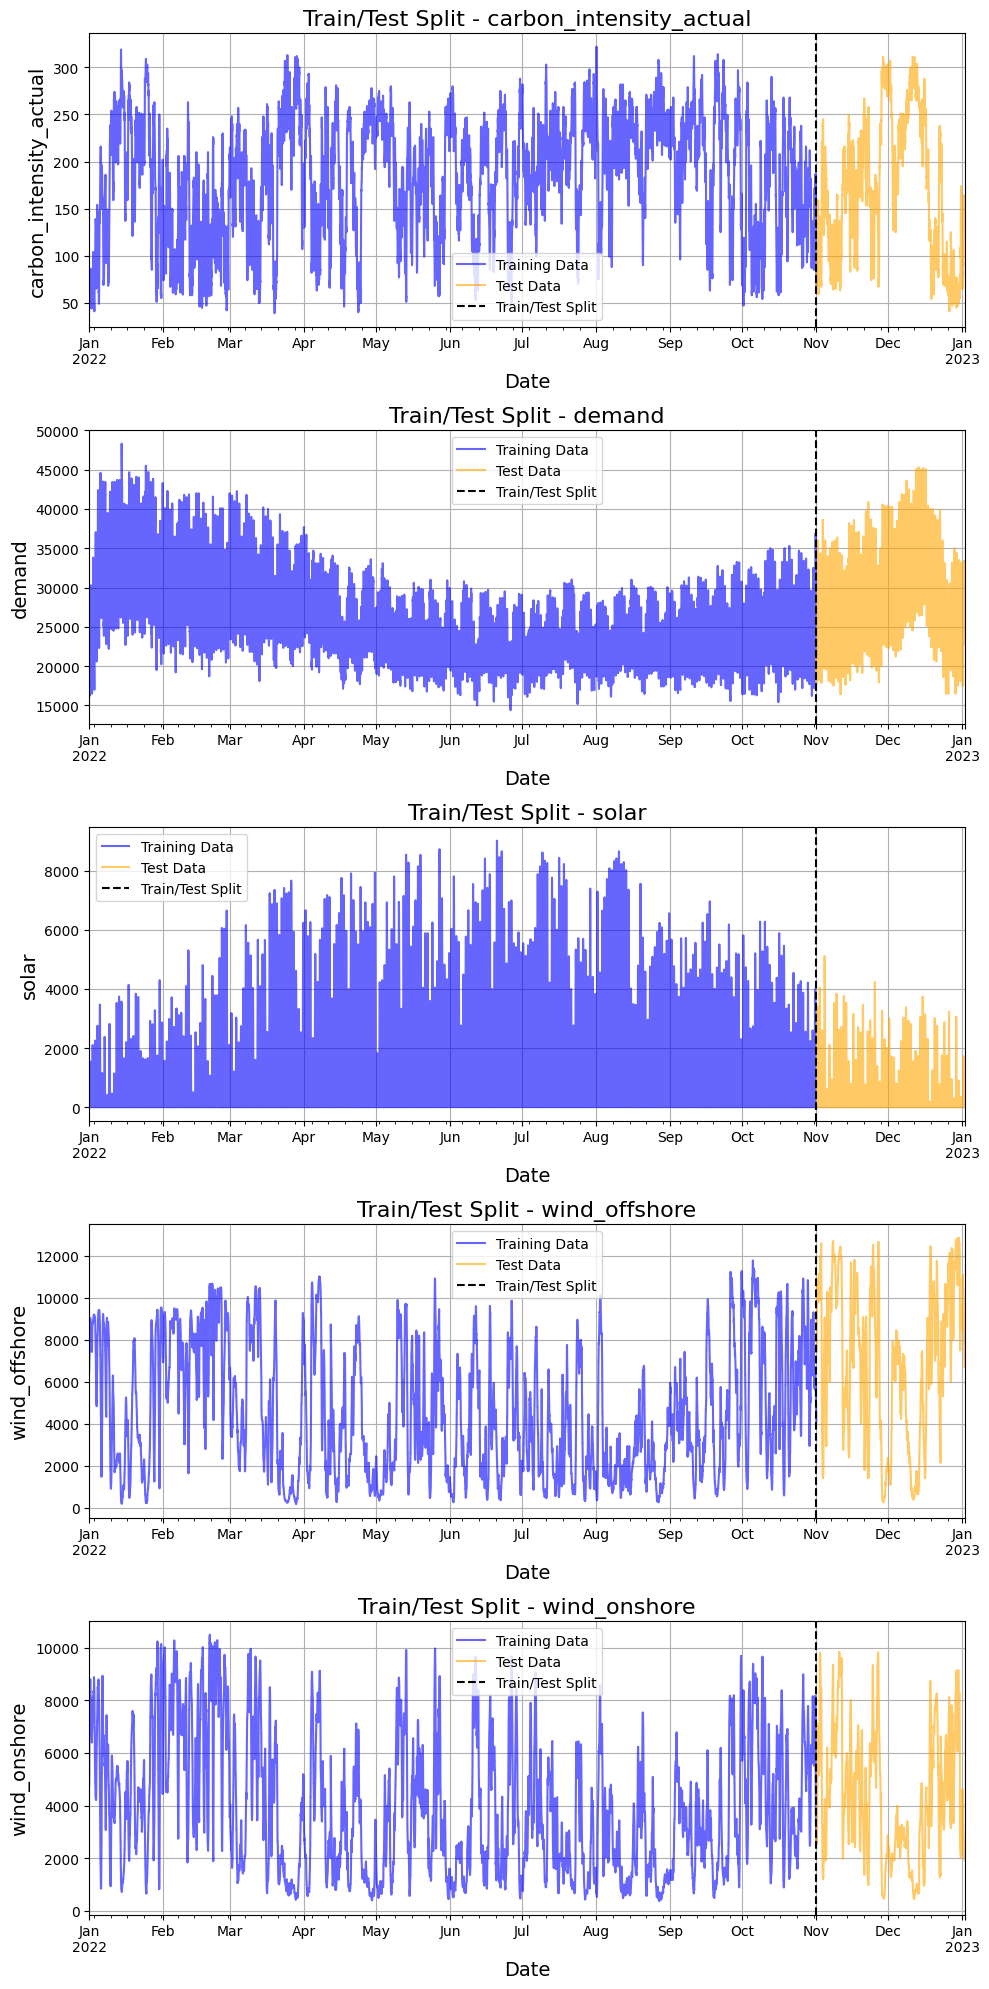

In [12]:
# First of November will be our split date:
split_date = "2022-11-01"

# Split the data
train = data_df[data_df.index < split_date]
test = data_df[data_df.index >= split_date]

cols_to_plot = ["carbon_intensity_actual", "demand", "solar", "wind_offshore", "wind_onshore"]

fig, axes = plt.subplots(len(cols_to_plot), 1, figsize=(10, 4 * len(cols_to_plot)))

# Loop through each column and plot
for ax, col in zip(axes, cols_to_plot): 
    train[col].plot(ax=ax, label="Training Data", color='blue', alpha=0.6)
    test[col].plot(ax=ax, label="Test Data", color='orange', alpha=0.6)
    
    # Vertical line for split date
    ax.axvline(pd.to_datetime(split_date), color="black", ls="--", label="Train/Test Split")
    ax.set_title(f"Train/Test Split - {col}", fontsize=16)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel(col, fontsize=14)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## Some Observations: 

### Carbon Intensity
- Fluctuates mainly between 50-300 gCO₂/kWh
- Shows high daily volatility
- No strong yearly seasonal pattern, but appears to have daily/weekly patterns. We would need a couple more years for better understanding. 
- Winter months (Nov-Dec test data) show higher average intensity, likely due to increased fossil fuel usage for heating

### Energy Demand
- Clear seasonal pattern: peaks in winter (30-45K MW), lower in summer (15-25K MW)
- Daily cycles visible in the detailed patterns but we can look at this a bit closer later
- Notable increase in demand during Nov-Dec 2022 (test period)
- Minimum demand never drops below 15K MW (base load)

### Solar Generation
- Strong seasonal and daily patterns
- Summer peaks reach ~8000 MW, winter peaks only ~4000 MW
- Zero generation during nights creates regular gaps
- Clear decline in maximum generation moving from summer to winter months (Sad about living in UK :) 
- Lower variability in winter months due to shorter days and less intense sunlight

### Wind Generation (Offshore & Onshore)
- Both show high volatility and intermittency
- No clear yearly seasonality but suggests weather-dependent patterns
- Complementary generation patterns between wind and solar
- Wind generation can drop to near-zero during calm periods


## From this: 

We can expect that our model shows some multi-scale seasonality. We can spot this a bit more clearly in the next window

#### Lets plot the month of January:

Bit biased to only look at this month - but observations do stand for other months too. 

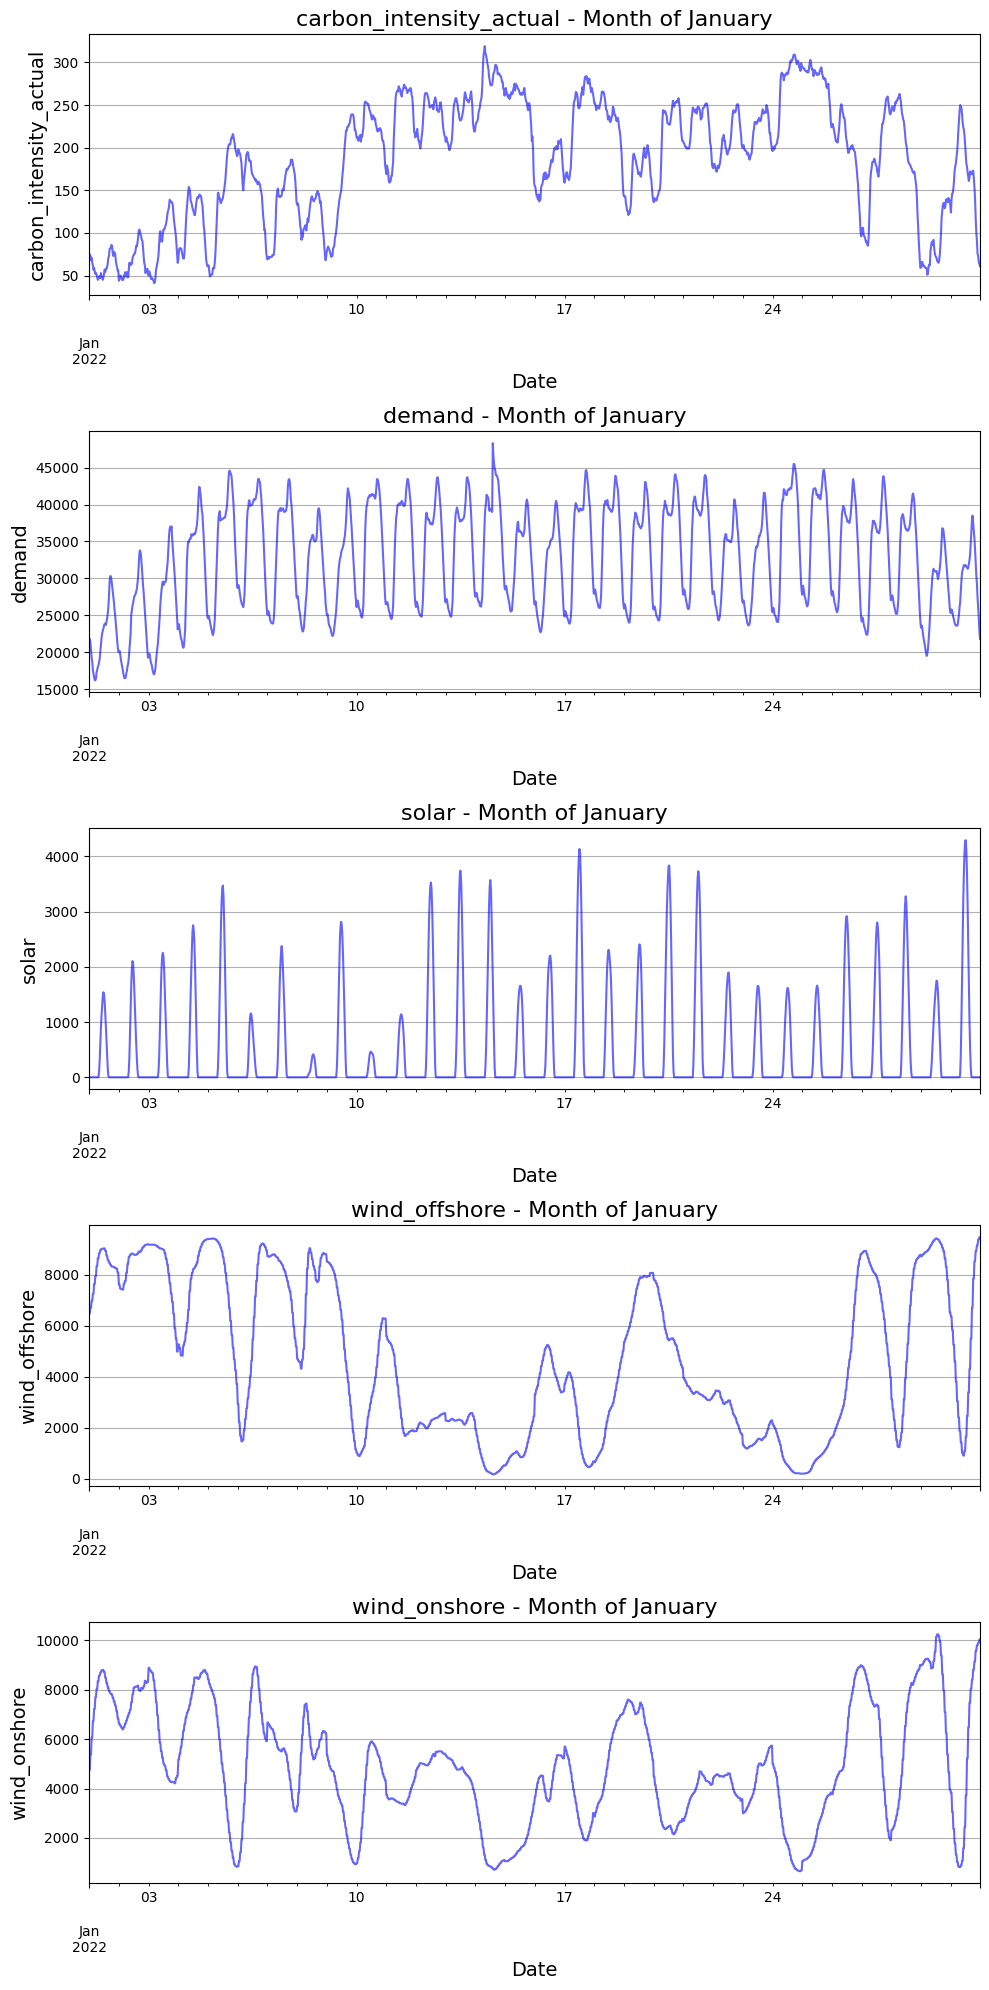

In [13]:
# Month of January
jan_df = data_df.loc[(data_df.index >= "2022-01-01") & (data_df.index  < "2022-01-31")]

fig, axes = plt.subplots(len(cols_to_plot), 1, figsize=(10, 4 * len(cols_to_plot)))
for ax, col in zip(axes, cols_to_plot): 
    jan_df[col].plot(ax=ax, color='blue', alpha=0.6)
        
    # Set titles and labels
    ax.set_title(f"{col} - Month of January", fontsize=16)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel(col, fontsize=14)
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()



1. Carbon intensity shows some daily patterns. Low intensity periods seem to coincide with when there is high wind production. Super interesting observations. 
2. Energy demand shows significant daily patterns, when people head for work, when they come home ect. We can see that its lower for the first days of the month as those days are bank holidays. 
3. Solar energy shows big peaks, as more light comes in at noon. On low days, most likely due to cloud cover. Rarely 0 as some light rays can hit pannels even when cloudy. 
4. wind generation show similar patterns, with sustained low and high patterns. 

### Plotting a week: 

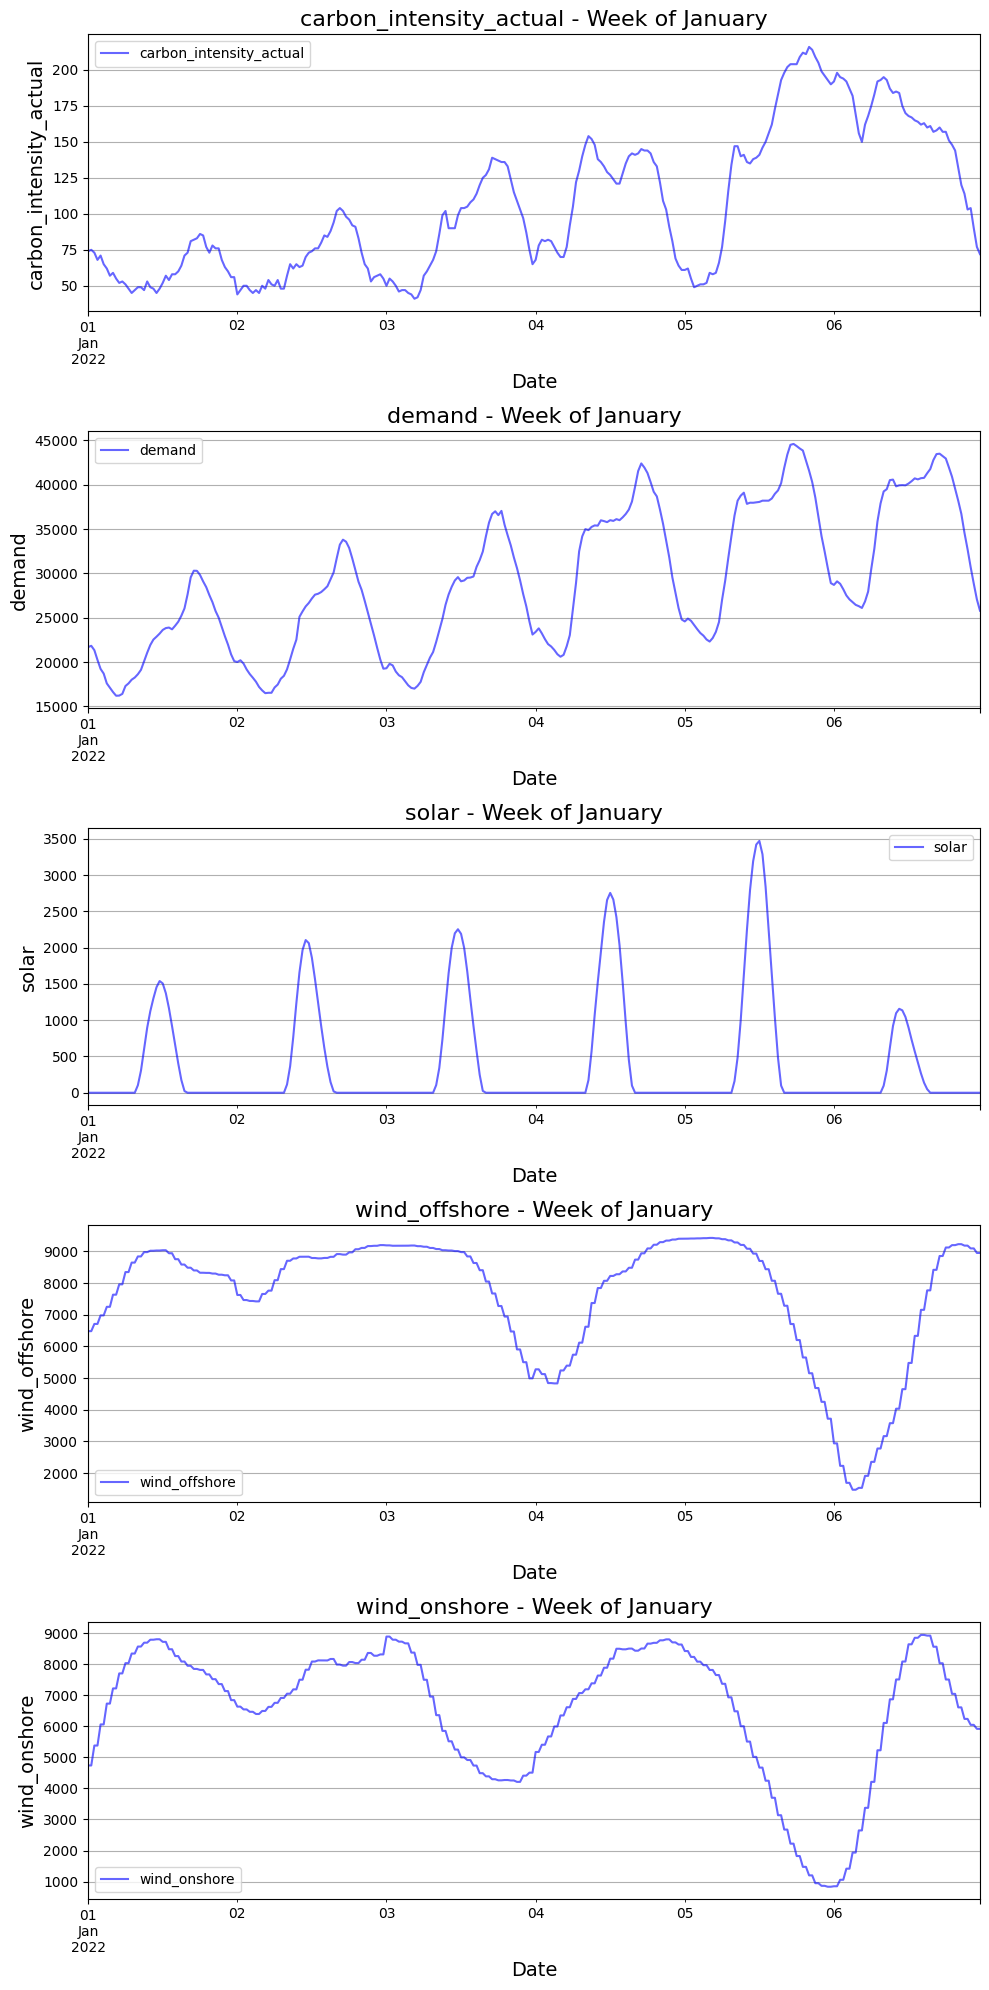

In [14]:
# Week:
jan_week_df = train.loc[(train.index >= "2022-01-01") & (train.index < "2022-01-07")]

# Create a larger figure to fit multiple plots
fig, axes = plt.subplots(len(cols_to_plot), 1, figsize=(10, 4 * len(cols_to_plot)))

# Loop through each column and plot
for ax, col in zip(axes, cols_to_plot): 
    jan_week_df[col].plot(ax=ax, color='blue', alpha=0.6)
        
    # Set titles and labels
    ax.set_title(f"{col} - Week of January", fontsize=16)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel(col, fontsize=14)
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


These just reinforce our observations and shows strong daily patterns. 

### Plotting a day: 

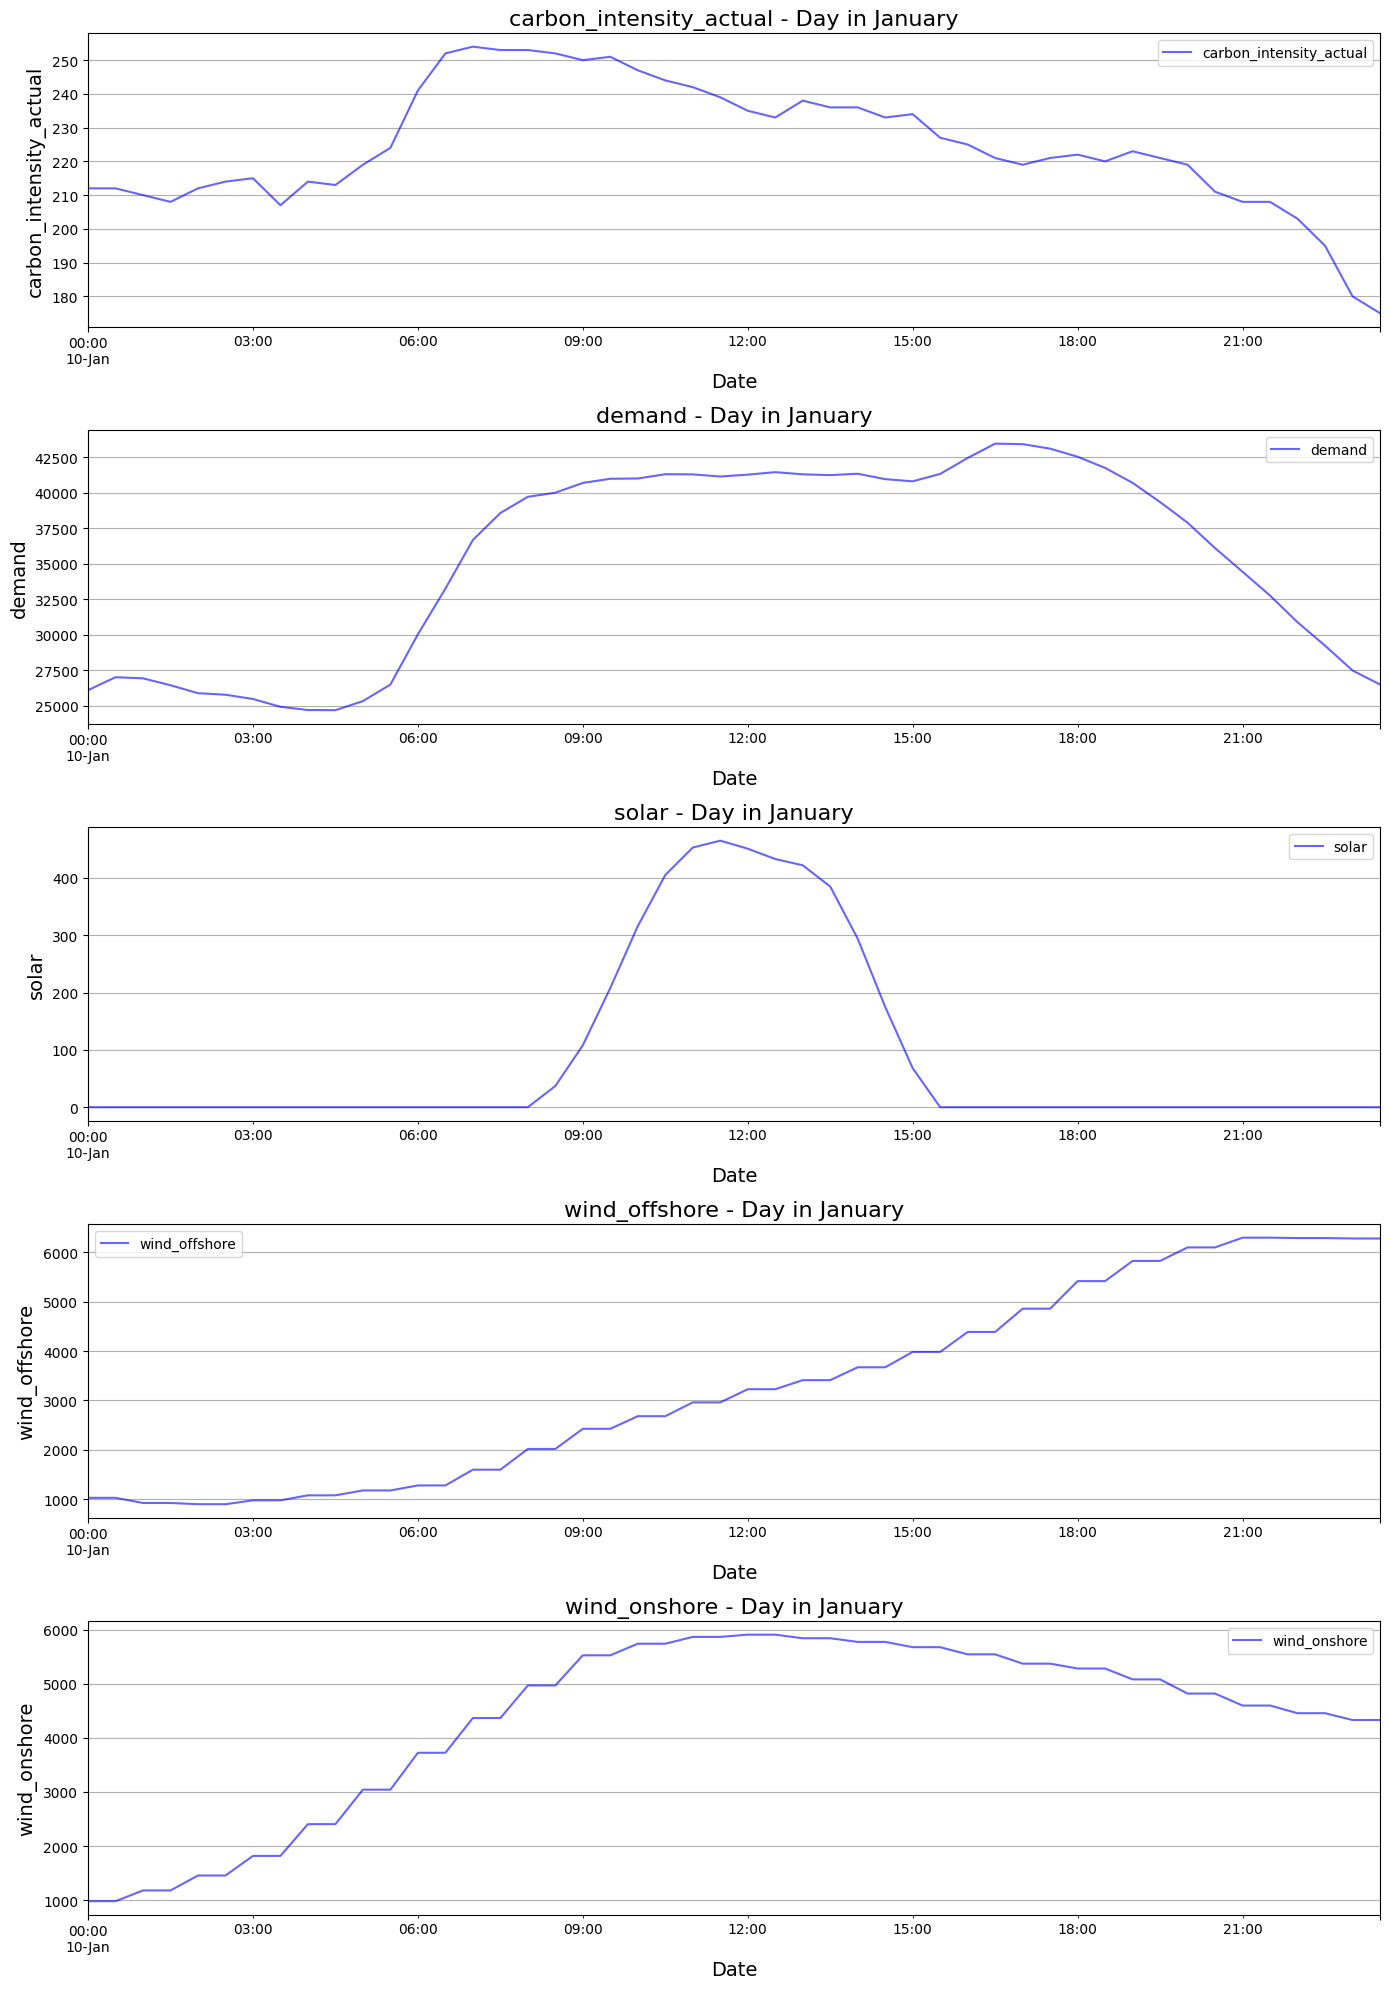

In [15]:
# Day: 
jan_day_df = train.loc[(train.index >= "2022-01-10") & (train.index < "2022-01-11")]


# Create a larger figure to fit multiple plots
fig, axes = plt.subplots(len(cols_to_plot), 1, figsize=(14, 4 * len(cols_to_plot)))

# Loop through each column and plot
for ax, col in zip(axes, cols_to_plot): 
    jan_day_df[col].plot(ax=ax, color='blue', alpha=0.6)
        
    # Set titles and labels
    ax.set_title(f"{col} - Day in January", fontsize=16)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel(col, fontsize=14)
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

We can clearly see here the demand pattern over the day. Starts strong when people wake up, then decreases during the day, and increases again in the evening.

# Lets now look at these patterns a bit closer with dates and times: 

In [16]:
def create_date_features(df: pd.DataFrame) -> pd.DataFrame:
   """Create time-based features from datetime index."""
   df = df.copy()
   
   # Extract temporal features
   df['minute'] = df.index.minute
   df['hour'] = df.index.hour 
   df['dayofweek'] = df.index.dayofweek  # Monday=0, Sunday=6
   df['month'] = df.index.month
   df['is_weekend'] = df.index.dayofweek > 4  # True for Sat/Sun
   
   return df

# Add temporal features to dataset
data_df = create_date_features(data_df)

Text(0.5, 1.0, 'Carbon intensity by hour')

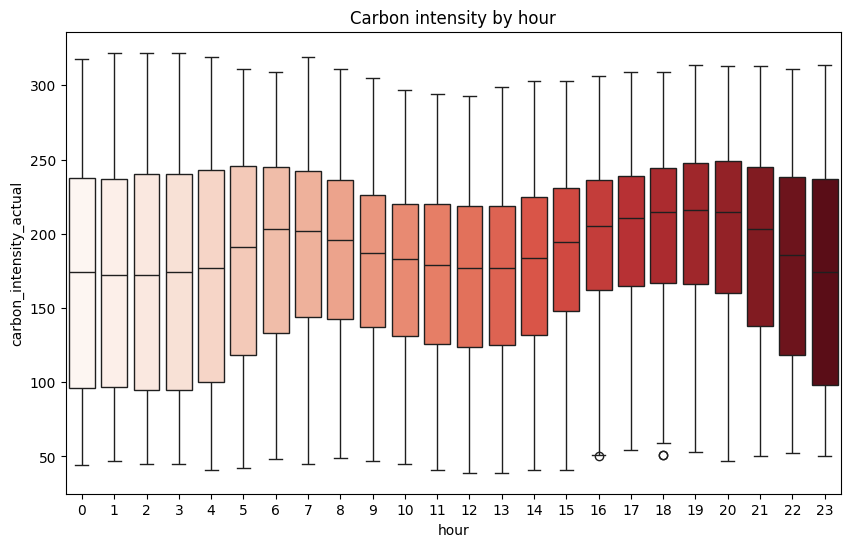

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=data_df, x="hour", y="carbon_intensity_actual", hue="hour", palette="Reds", ax=ax, legend=False)
ax.set_title("Carbon intensity by hour")

Carbon intensity stays quite level in early hours and late nights.

During work day, we can notice a slight increase, followed by slight decrease lunchtime as people leave office, picks up again after. 

After work, a slight increase when people head home and need more electricity (meaning more electricity production).

Seems to be quite correalted to energy demand. 

Text(0.5, 1.0, 'Carbon intensity by Month')

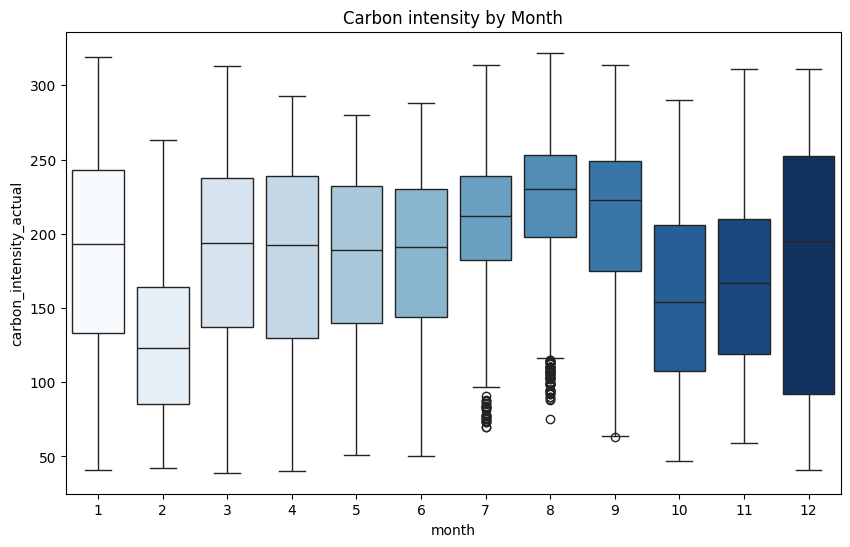

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=data_df, x="month", y="carbon_intensity_actual", hue="month", palette="Blues", ax=ax, legend=False)
ax.set_title("Carbon intensity by Month")

A little bit asymetric. Goes up in the summer, probably due to cooling infrastructure. Seems to go down a bit in the winters. This is quite surprising as we showed there was less solar energy production. But potentially correlated to wind and others.  

Text(0.5, 1.0, 'Carbon intensity by day of week')

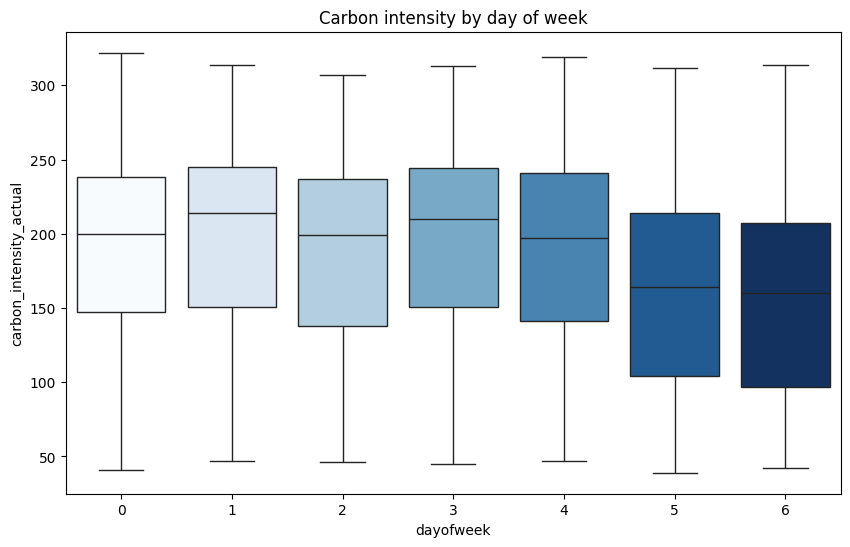

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=data_df, x="dayofweek", y="carbon_intensity_actual", hue="dayofweek", palette="Blues", ax=ax, legend=False)
ax.set_title("Carbon intensity by day of week")

Can observe a dip on the weekends - less people at work, so less electricity demand. This leads to less energy production, and less carbon intensity. 

## Sationarity: 

Stationarity is necessary when modelling time-series and requires a constant mean and variance in time. 

In [20]:
# check for stationarity:
cols_to_use = ["carbon_intensity_actual", "demand", "solar", "wind_offshore", "wind_onshore"]

for col in data_df.columns:
    result = adfuller(data_df[col])
    print(f"{col} - ADF Statistic: {result[0]:.3f}, p-value: {result[1]:.3f}")

carbon_intensity_actual - ADF Statistic: -7.797, p-value: 0.000
carbon_intensity_forecast - ADF Statistic: -7.651, p-value: 0.000
demand - ADF Statistic: -2.843, p-value: 0.052
solar - ADF Statistic: -5.598, p-value: 0.000
wind_offshore - ADF Statistic: -8.744, p-value: 0.000
wind_onshore - ADF Statistic: -9.901, p-value: 0.000
minute - ADF Statistic: -1044958465275.910, p-value: 0.000
hour - ADF Statistic: -132.110, p-value: 0.000
dayofweek - ADF Statistic: -11.685, p-value: 0.000
month - ADF Statistic: -1.663, p-value: 0.450
is_weekend - ADF Statistic: -11.282, p-value: 0.000


Great, so all our columns are stationary. They do show some seasonality, but this could be predicted by integrating time features.

# Conclusions: 

Now that we understand our data a bit better, we can thinkg of a few extra things before heading into the modelling notebook: 

1. Normalising the features: Normalization scales the features to a common range, leading to faster convergence and better performance. As we will be using XGBoost for predictions, normalisation is not necessary.

2. Setup a Time-split Cross-Validation

3. Think of extra features to add. 

### Normalising:

This can easily be done with a MinMax Scaler which would scale the values between 0 and 1. Would need to fit the scaler on the training data to not leak anything into the test set. 

### Cross-Validation: 

- Cross-val can be handled using a method from Sklearn, and lets stick with 5 for now. 
- These can be used for some hyperparamter tuning for our models. 

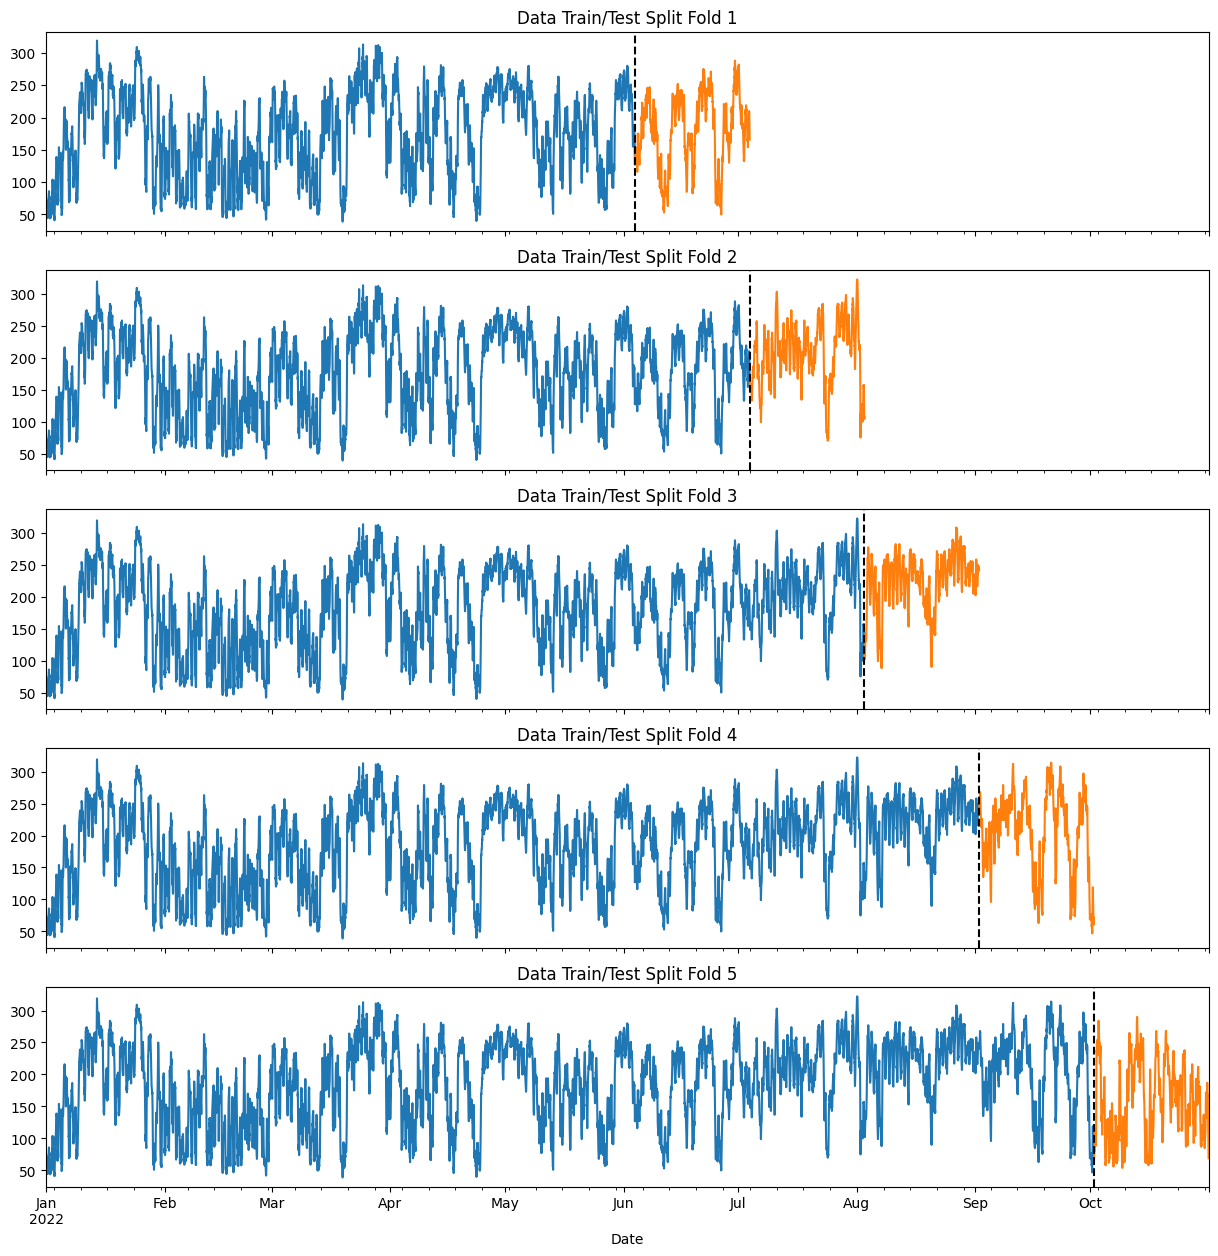

In [21]:
split_date = "2022-11-01"

train_data = data_df[data_df.index < split_date]
test_data = data_df[data_df.index >= split_date]

# Validation size of 1 month = 48 values in 1 day and month has 30 days:
tss = TimeSeriesSplit(n_splits=5, test_size=48*30*1, gap=0)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(train_data):
    train = train_data.iloc[train_idx]
    test = train_data.iloc[val_idx]
    train['carbon_intensity_actual'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold + 1}')
    test['carbon_intensity_actual'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Looks good and should be nice for our modelling. In reality, it would be much better to have more data and larger validation and test sizes, to make sure we are generalising the best we can. 

# Extra Features to setup: 

1. First it would be good to include some date and time features. These could include current time, minutes, day of the week and if today is a weekend. 
2. Next we could use some past data, also called lags, for better model performance. This would entail using yeseterdays carbon intensity values, as todays are likely to be close to those. 
3. Next we could implement some extra forecasts features. We currently only have the forecasts for wind and solar energy as well as energy demand. However, Carbon intensity is highly correlated to how much fossil fual we are using on the grid. As these are the ones emiting significant amounts of CO2. So finding a way to incorporate some of this information will be really useful - Even just forecasts. 
4. Finally, adding weather forecasts would be very interesting, including potential cloud cover, temperatures, pressures, precipitaiton and others. 



# Extra things we couldve looked into include: 

- Look at autocorrelations and correlations between the features - to spot interesting lags. 
- We couldve decomposed some of the seasonality, but we were still able to model well without this. 

# Lets now move to the modelling notebook :) 